# README.

This notebook shows how to do some very basic analysis of the measurements.

In [1]:
%matplotlib inline
import dbutils
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import date
from time import mktime
import calendar


# Where to store outputs.
output_path = "."

# Connect to database.
main_connector = dbutils.connect_to_main_database()

# Getting the columns of the tables.

In [2]:
# Getting the tables.
sql_statement = "select * from information_schema.tables where table_schema != 'information_schema'"
results = main_connector.execute(sql_statement, fetch_all=True)
tables = [result[2] for result in results if result[1] == "public"]

# Getting the colums of the tables.
for table in tables:
    print(table, "\n\t", "\n\t".join(main_connector.get_columns(table)))

artifact_quality 
	 type
	key
	value
	misc
	artifact_id
artifact 
	 id
	measure_id
	type
	path
	hash_value
	file_size
	upload_date
	deleted
	qr_code
	create_date
	created_by
	tango_timestamp
	status
measurements 
	 id
	measurement_id
	person_id
	qrcode
	sex
	type
	age_days
	height_cms
	weight_kgs
	muac_cms
	head_circumference_cms
	oedema
	latitude
	longitude
	address
	timestamp
	deleted
	deleted_by
	visible
	created_by
image_data 
	 id
	path
	qrcode
	last_updated
	rejected_by_expert
	had_error
	error_message
	blur_variance
pointcloud_data 
	 id
	path
	qrcode
	last_updated
	rejected_by_expert
	had_error
	error_message
	number_of_points
	confidence_min
	confidence_avg
	confidence_std
	confidence_max
	centroid_x
	centroid_y
	centroid_z
	stdev_x
	stdev_y
	stdev_z
artifacts_with_targets 
	 qr_code
	artifact_id
	artifact_path
	type
	age
	height
	weight
	muac
	head_circumference
person 
	 id
	name
	surname
	birthday
	sex
	guardian
	is_age_estimated
	qr_code
	created
	timestamp
	created_by
	de

# Simple analytics.

In [24]:
main_connector = dbutils.connect_to_main_database()

sql_statement = "SELECT COUNT(*) FROM person;"
result = main_connector.execute(sql_statement, fetch_all=True)[0][0]
print(result, "persons")

sql_statement = "SELECT COUNT(*) FROM measure;"
result = main_connector.execute(sql_statement, fetch_all=True)[0][0]
print(result, "measures")
   
sql_statement = "SELECT COUNT(*) FROM artifact;"
result = main_connector.execute(sql_statement, fetch_all=True)[0][0]
print(result, "artifacts")

sql_statement = "SELECT COUNT(*) FROM artifact WHERE type='rgb';"
result = main_connector.execute(sql_statement, fetch_all=True)[0][0]
print(result, "artifacts with type rgb")

sql_statement = "SELECT COUNT(*) FROM artifact WHERE type='pcd';"
result = main_connector.execute(sql_statement, fetch_all=True)[0][0]
print(result, "artifacts with type pcd")

sql_statement = "SELECT COUNT(*) FROM artifact WHERE measure_id IS NOT NULL;"
result = main_connector.execute(sql_statement, fetch_all=True)[0][0]
print(result, "artifacts with measure")

sql_statement = "SELECT COUNT(*) FROM artifact WHERE measure_id IS NULL;"
result = main_connector.execute(sql_statement, fetch_all=True)[0][0]
print(result, "artifacts without measure")
    
sql_statement = "SELECT SUM(file_size) FROM artifact;"
result = main_connector.execute(sql_statement, fetch_all=True)[0][0]
print(int(result / (1024 * 1024 * 1024)), "GB artifacts data")

sql_statement = "SELECT SUM(file_size) FROM artifact WHERE type='rgb';"
result = main_connector.execute(sql_statement, fetch_all=True)[0][0]
print(int(result / (1024 * 1024 * 1024)), "GB artifacts data with type rgb")
      
sql_statement = "SELECT SUM(file_size) FROM artifact WHERE type='pcd';"
result = main_connector.execute(sql_statement, fetch_all=True)[0][0]
print(int(result / (1024 * 1024 * 1024)), "GB artifacts data with type pcd")

sql_statement = "SELECT COUNT(DISTINCT(qr_code)) FROM artifact;"
result = main_connector.execute(sql_statement, fetch_all=True)[0][0]
print(result, "QR codes")

sql_statement = "SELECT COUNT(DISTINCT(qr_code)) FROM artifact WHERE measure_id IS NULL;"
result = main_connector.execute(sql_statement, fetch_all=True)[0][0]
print(result, "QR codes without measure_id")

sql_statement = "SELECT COUNT(*) FROM artifact_quality;"
result = main_connector.execute(sql_statement, fetch_all=True)[0][0]
print(result, "artifact quality KPIs")

6990 persons
13739 measures
966811 artifacts
743562 artifacts with type rgb
223249 artifacts with type pcd
630017 artifacts with measure
336794 artifacts without measure
378 GB artifacts data
80 GB artifacts data with type rgb
297 GB artifacts data with type pcd
5213 QR codes
1853 QR codes without measure_id
210292 artifact quality KPIs


# Getting statistical values of measurements.

In [6]:
columns = [
 'age',
 'height',
 'weight',
 'muac',
 'head_circumference',
]

headers = []
rows = []
for column in columns:
    sql_statement = "SELECT MIN({0}), AVG({0}), MAX({0}) FROM measure;".format(column)
    minimum, average, maximum = main_connector.execute(sql_statement, fetch_one=True)
    
    rows.append([column, minimum, average, maximum])
    
headers = ("key", "minimum", "average", "maximum")
df = pd.DataFrame(rows, columns=headers)
df

,key,minimum,average,maximum
0,age,0.0,1098.1582356794526530,17834.0
1,height,0.0,43.4181,997.9
2,weight,0.0,5.53544,714.6
3,muac,0.0,7.08521,170.0
4,head_circumference,0.0,23.1865,446.0


# Creating pie charts for some columns.

In [ ]:
from collections import Counter

def make_pie(key):
    sql_statement = "SELECT {} FROM measure;".format(key)
    values_list = main_connector.execute(sql_statement, fetch_all=True)

    most_common = Counter(values_list).most_common(10000)

    # TODO percent
    values = []
    keys = []
    for key, value in most_common:
        print(key, value)
        keys.append(str(key))
        values.append(value)
        
    plt.figure(figsize=(15, 15))
    patches, texts = plt.pie(values)
    plt.legend(patches, keys)
    plt.title(df_key)
    plt.savefig(os.path.join(output_path, "pie-{}.png".format(df_key)))

    
df_keys = ["created_by", "oedema"]
for df_key in df_keys:
    make_pie(df_key)

# Render histograms.

In [ ]:
def render_histogram(key, values, bins):
    hist = plt.hist(values, bins=bins)
    plt.savefig("histogram-{}.png".format(key))
    plt.show()
    
render_parameters = []
render_parameters.append(("age", 100))
render_parameters.append(("height", 100))
render_parameters.append(("weight", 100))
render_parameters.append(("muac", 100))
for key, bins in render_parameters:
    sql_statement = "SELECT {} FROM measure WHERE type='manual'".format(key)
    results = main_connector.execute(sql_statement, fetch_all=True)
    values = [result[0] for result in results]
    print(values[0:10])
    render_histogram(key, values, bins)

# Rendering the measurements over time.

No handles with labels found to put in legend.


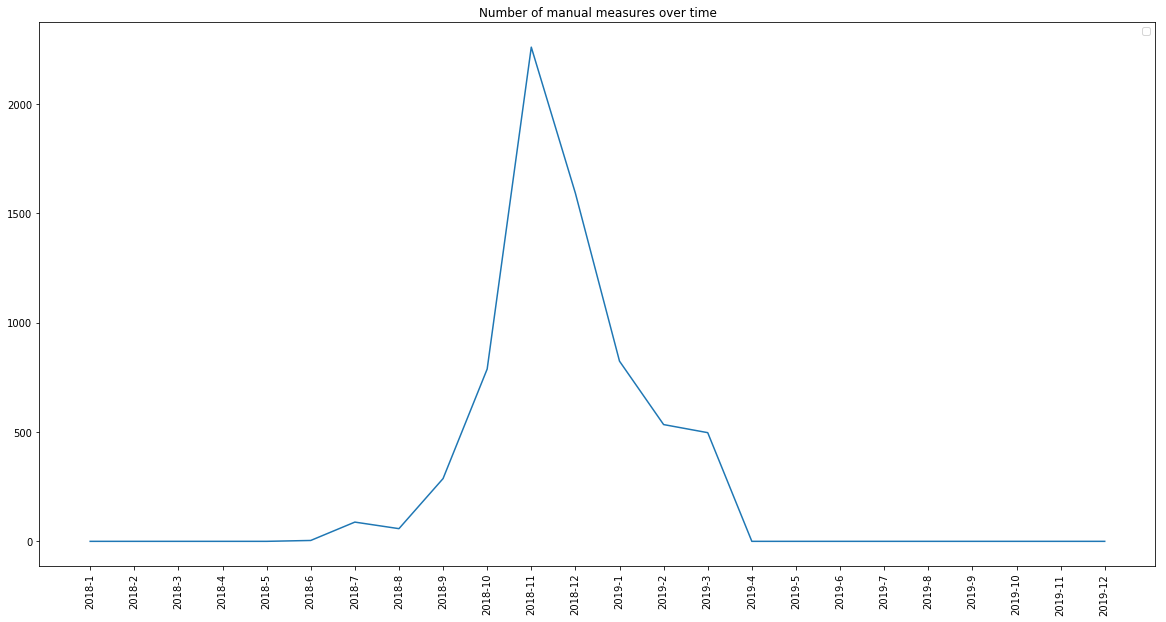

In [8]:
plot_values = []
plot_labels = []
for year in [2018, 2019]:
    for month in range(1, 13):
        
        # Getting the start.
        start_day = 1
        start_date = date(year, month, start_day)
        start_timestamp = str(1000 * int(mktime(start_date.timetuple())))
        
        # Getting the end.
        _, end_day = calendar.monthrange(year, month)
        end_date = date(year, month, end_day)
        end_timestamp = str(1000 * int(mktime(end_date.timetuple())))

        # Getting the number of entries from the database.
        sql_statement = ""
        sql_statement += "SELECT COUNT(*) FROM measure"
        sql_statement += " WHERE type='manual'"
        sql_statement += " AND timestamp >= {}".format(start_timestamp)
        sql_statement += " AND timestamp <= {}".format(end_timestamp)
        number_of_entries = main_connector.execute(sql_statement, fetch_one=True)[0]
        
        # Prepare the plot.
        plot_values.append(number_of_entries)
        plot_labels.append("{}-{}".format(year, month))
        
# Plot the plot.
plt.figure(figsize=(20,10))
plt.plot(plot_values)
plt.xticks(range(len(plot_labels)), plot_labels, rotation='vertical')
plt.legend()
plt.title("Number of manual measures over time")
plt.show()
plt.close()

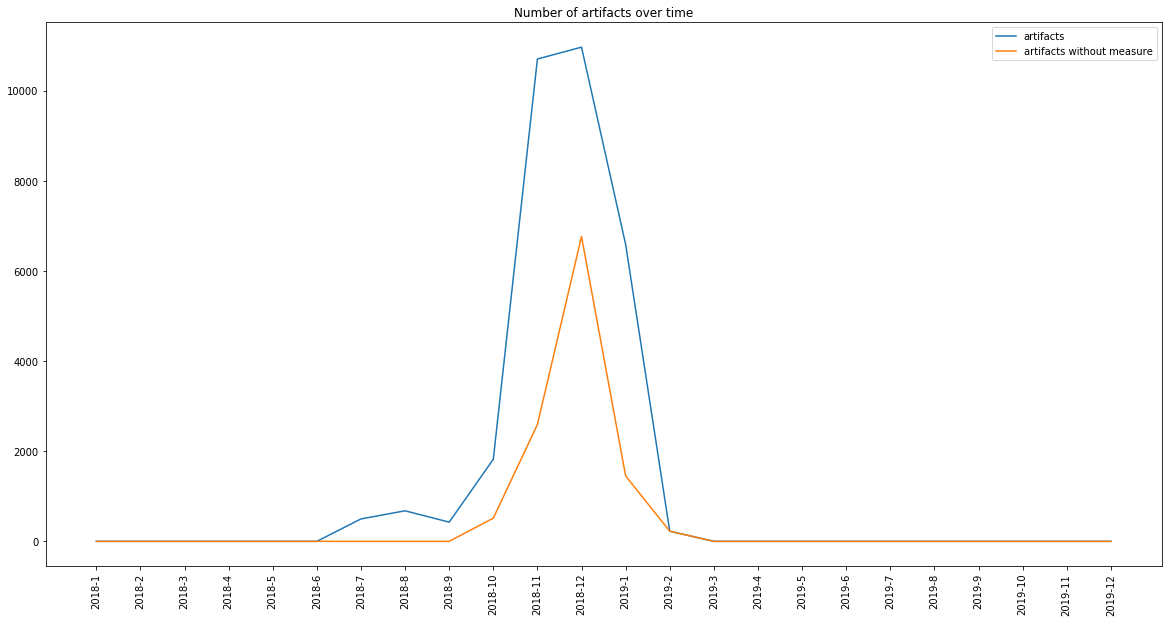

In [9]:
plot_values = []
plot_values_no_measure = []
plot_labels = []
for year in [2018, 2019]:
    for month in range(1, 13):
        
        # Getting the start.
        start_day = 1
        start_date = date(year, month, start_day)
        start_timestamp = str(1000 * int(mktime(start_date.timetuple())))
        
        # Getting the end.
        _, end_day = calendar.monthrange(year, month)
        end_date = date(year, month, end_day)
        end_timestamp = str(1000 * int(mktime(end_date.timetuple())))

        # Getting the number of artifacts.
        sql_statement = ""
        sql_statement += "SELECT COUNT(*) FROM artifact"
        sql_statement += " WHERE create_date >= {}".format(start_timestamp)
        sql_statement += " AND create_date <= {}".format(end_timestamp)
        number_of_entries = main_connector.execute(sql_statement, fetch_one=True)[0]
        plot_values.append(number_of_entries)
        
        # Getting the number of artifacts without measures.
        sql_statement = ""
        sql_statement += "SELECT COUNT(*) FROM artifact"
        sql_statement += " WHERE create_date >= {}".format(start_timestamp)
        sql_statement += " AND create_date <= {}".format(end_timestamp)
        sql_statement += " AND measure_id IS NULL"
        number_of_entries = main_connector.execute(sql_statement, fetch_one=True)[0]
        plot_values_no_measure.append(number_of_entries)
        
        plot_labels.append("{}-{}".format(year, month))
        
# Plot the plot.
plt.figure(figsize=(20, 10))
plt.plot(plot_values, label="artifacts")
plt.plot(plot_values_no_measure, label="artifacts without measure")
plt.xticks(range(len(plot_labels)), plot_labels, rotation='vertical')
plt.legend()
plt.title("Number of artifacts over time")
plt.show()
plt.close()

# Available data in GBs.

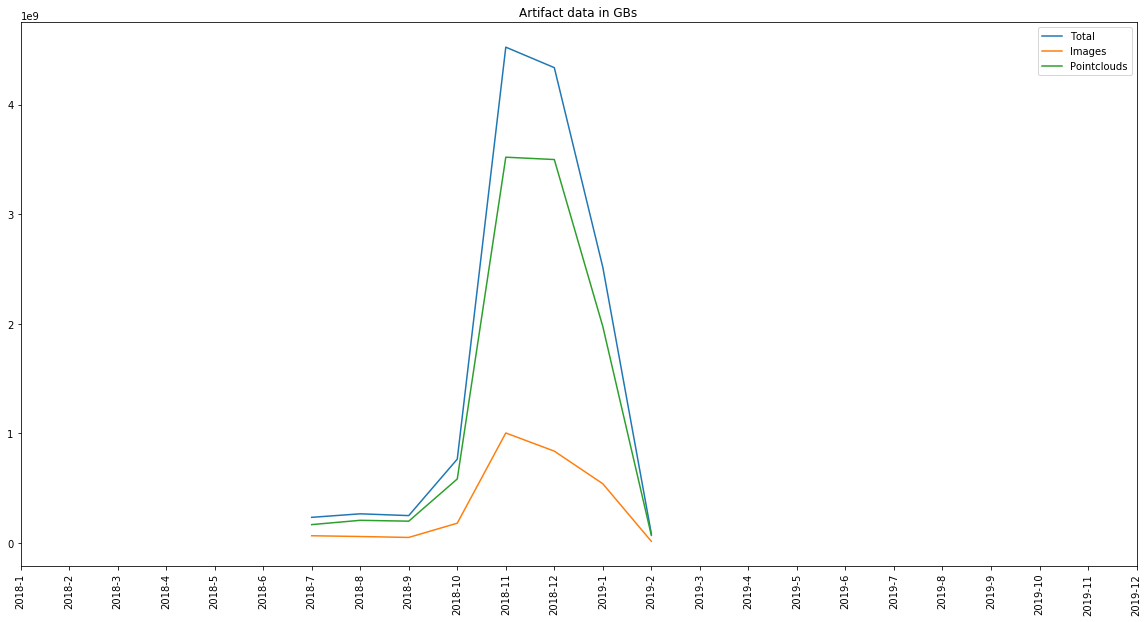

In [10]:
plot_values_total = []
plot_values_images = []
plot_values_pointclouds = []
plot_labels = []
for year in [2018, 2019]:
    for month in range(1, 13):
        
        # Getting the start.
        start_day = 1
        start_date = date(year, month, start_day)
        start_timestamp = str(1000 * int(mktime(start_date.timetuple())))
        
        # Getting the end.
        _, end_day = calendar.monthrange(year, month)
        end_date = date(year, month, end_day)
        end_timestamp = str(1000 * int(mktime(end_date.timetuple())))

        # Getting the overall filesize.
        sql_statement = ""
        sql_statement += "SELECT SUM(file_size) FROM artifact"
        sql_statement += " WHERE create_date >= {}".format(start_timestamp)
        sql_statement += " AND create_date <= {}".format(end_timestamp)
        number_of_entries = main_connector.execute(sql_statement, fetch_one=True)[0]
        plot_values_total.append(number_of_entries)
        
        # Getting the overall filesize.
        sql_statement = ""
        sql_statement += "SELECT SUM(file_size) FROM artifact"
        sql_statement += " WHERE create_date >= {}".format(start_timestamp)
        sql_statement += " AND create_date <= {}".format(end_timestamp)
        sql_statement += " AND type='rgb'"
        number_of_entries = main_connector.execute(sql_statement, fetch_one=True)[0]
        plot_values_images.append(number_of_entries)
        
        # Getting the overall filesize.
        sql_statement = ""
        sql_statement += "SELECT SUM(file_size) FROM artifact"
        sql_statement += " WHERE create_date >= {}".format(start_timestamp)
        sql_statement += " AND create_date <= {}".format(end_timestamp)
        sql_statement += " AND type='pcd'"
        number_of_entries = main_connector.execute(sql_statement, fetch_one=True)[0]
        plot_values_pointclouds.append(number_of_entries)

        # Labels
        plot_labels.append("{}-{}".format(year, month))
        
# Plot the plot.
plt.figure(figsize=(20,10))
plt.plot(plot_values_total, label="Total")
plt.plot(plot_values_images, label="Images")
plt.plot(plot_values_pointclouds, label="Pointclouds")
plt.xticks(range(len(plot_labels)), plot_labels, rotation='vertical')
plt.legend()
plt.title("Artifact data in GBs")
plt.show()
plt.close()

No handles with labels found to put in legend.


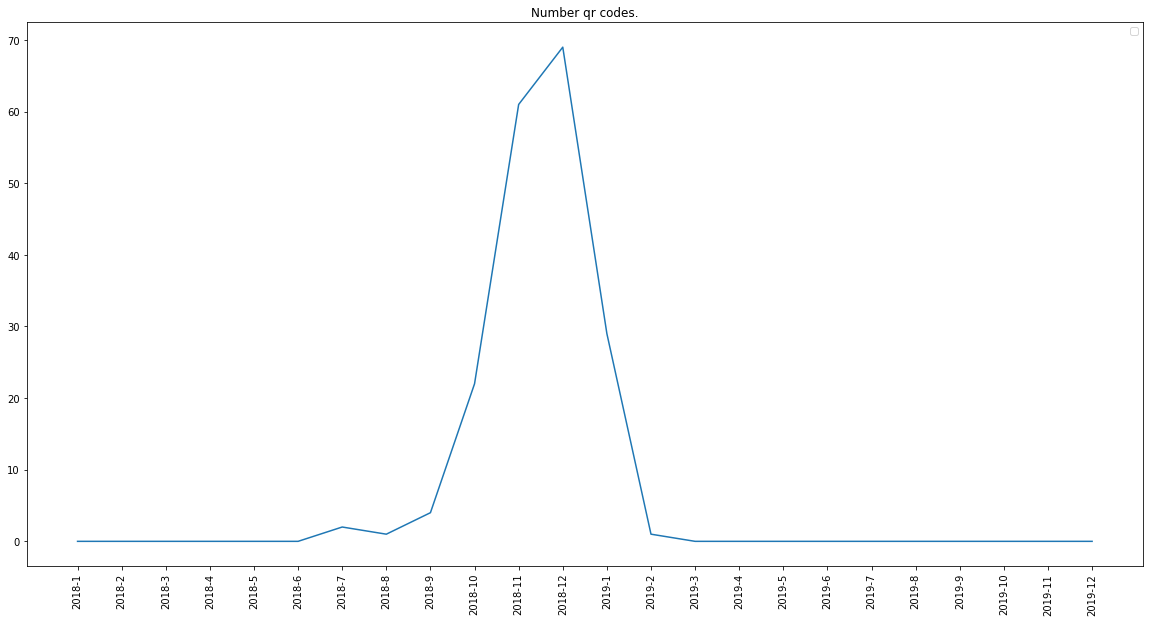

In [11]:
plot_values = []
plot_labels = []
for year in [2018, 2019]:
    for month in range(1, 13):
        
        # Getting the start.
        start_day = 1
        start_date = date(year, month, start_day)
        start_timestamp = str(1000 * int(mktime(start_date.timetuple())))
        
        # Getting the end.
        _, end_day = calendar.monthrange(year, month)
        end_date = date(year, month, end_day)
        end_timestamp = str(1000 * int(mktime(end_date.timetuple())))

        # Getting the number of entries from the database.
        sql_statement = ""
        sql_statement += "SELECT COUNT(DISTINCT(qr_code)) FROM artifact"
        sql_statement += " WHERE create_date >= {}".format(start_timestamp)
        sql_statement += " AND create_date <= {}".format(end_timestamp)
        number_of_entries = main_connector.execute(sql_statement, fetch_one=True)[0]
        
        # Prepare the plot.
        plot_values.append(number_of_entries)
        plot_labels.append("{}-{}".format(year, month))
        
# Plot the plot.
plt.figure(figsize=(20,10))
plt.plot(plot_values)
plt.xticks(range(len(plot_labels)), plot_labels, rotation='vertical')
plt.legend()
plt.title("Number qr codes.")
plt.show()
plt.close()

926 artifact quality KPIs
0.0 artifact quality KPIs
